# Shashwat Jain
## Advance Computer Vision Lab - 8
## Task 1:

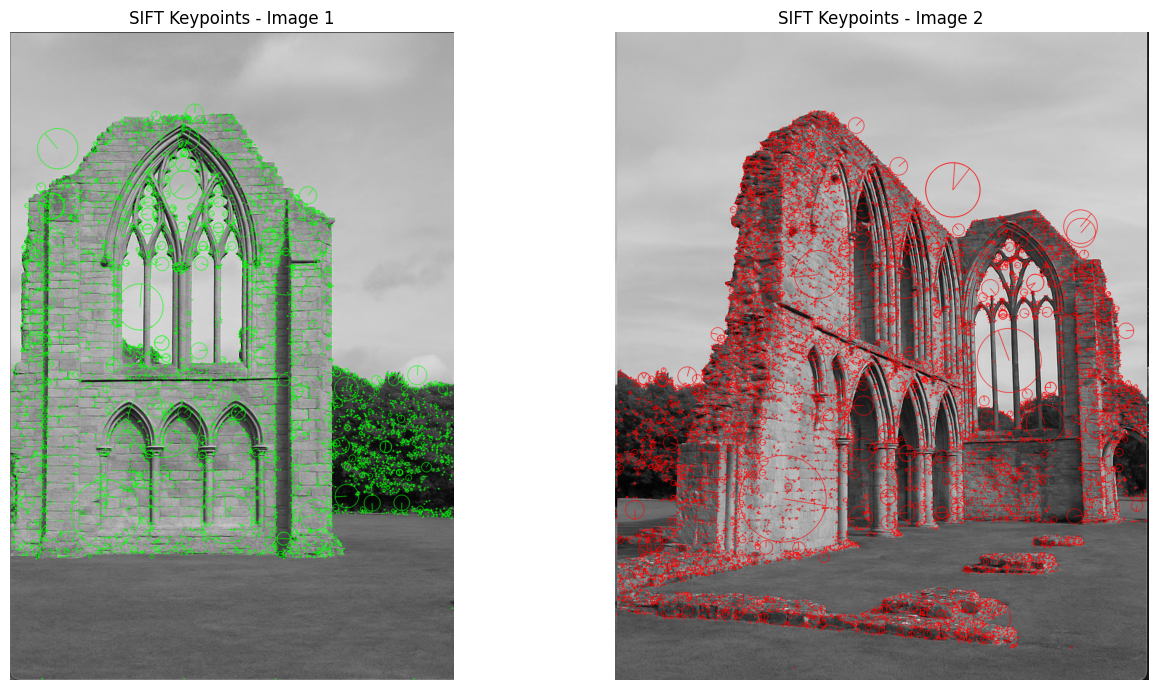

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load grayscale images with better error handling
img1_path = '/content/SFM left.png'
img2_path = '/content/SFM right.png'

img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    raise FileNotFoundError("One or both image paths are incorrect or the files are not found.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Draw keypoints with custom color and thickness for better visibility
img1_kp = cv2.drawKeypoints(
    img1, keypoints1, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(
    img2, keypoints2, None, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Use 'gray' colormap to maintain consistency and clarity in display
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp)
plt.title("SIFT Keypoints - Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_kp)
plt.title("SIFT Keypoints - Image 2")
plt.axis('off')

plt.tight_layout()
plt.show()


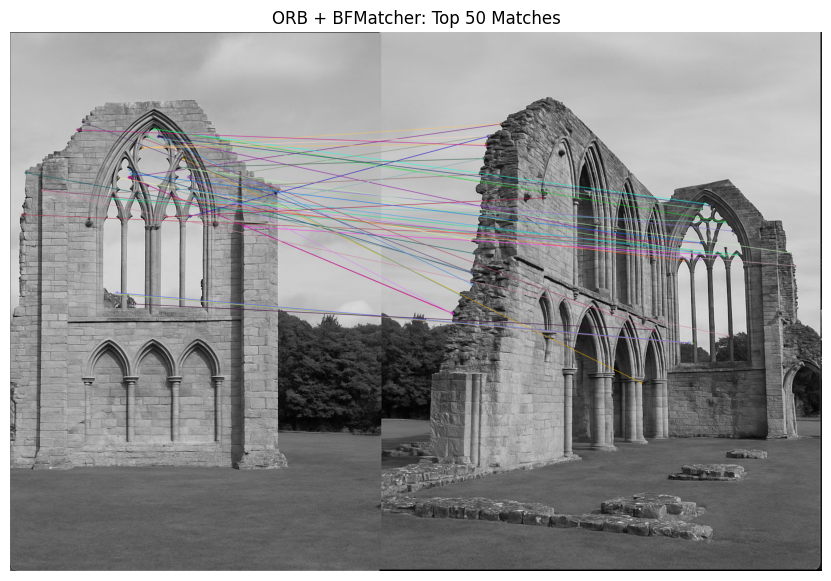

In [ ]:
# 2. Feature Matching using ORB + BFMatcher
# Load ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors using ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Use BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  #used for matching binary descriptors, mutual matching

# Match descriptors
matches = bf.match(des1, des2) #comparison of descriptors in images

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 50 matches
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

# Show result
plt.figure(figsize=(15, 7))
plt.imshow(matched_img), plt.title("ORB + BFMatcher: Top 50 Matches")
plt.axis("off")
plt.show()


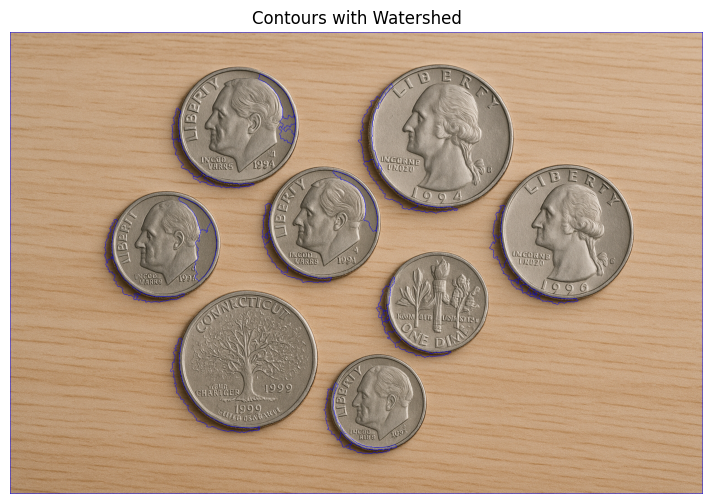

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read and convert image
img = cv2.imread('/content/circle.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5) #calculates the distance of each pixel to the nearest zero pixel.
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]  # Mark borders in red

# Display contours
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Contours with Watershed")
plt.axis("off")
plt.show()


100%|██████████| 169M/169M [00:12<00:00, 13.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weig


Training ResNet18...
Epoch 1, Loss: 2.8746
Epoch 2, Loss: 2.1264
Epoch 3, Loss: 1.7868
Training Time: 67.76 seconds
Accuracy: 46.91%

Training ResNet34...
Epoch 1, Loss: 3.2023
Epoch 2, Loss: 2.7099
Epoch 3, Loss: 2.3760
Training Time: 103.00 seconds
Accuracy: 42.26%


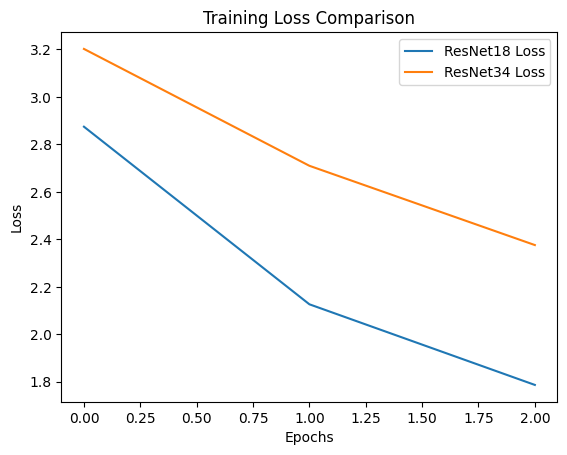


Comparison:
ResNet18 Accuracy: 46.91%
ResNet34 Accuracy: 42.26%


In [ ]:
#task 2.1 : Resnet

import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define training function
def train_model(model, epochs=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    end_time = time.time()
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return train_losses, model

# Evaluation function
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Load ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)

# Load ResNet34
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)

print("\nTraining ResNet18...")
loss18, model18 = train_model(resnet18)
acc18 = evaluate_model(model18)

print("\nTraining ResNet34...")
loss34, model34 = train_model(resnet34)
acc34 = evaluate_model(model34)


plt.plot(loss18, label='ResNet18 Loss')
plt.plot(loss34, label='ResNet34 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


print(f"\nComparison:\nResNet18 Accuracy: {acc18:.2f}%\nResNet34 Accuracy: {acc34:.2f}%")